In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.axes import Axes
from scipy.stats import t
from scipy.stats import ttest_ind, median_test


import warnings
warnings.filterwarnings('ignore')

###  1. Загрузка данных

In [164]:
active_users = pd.read_csv('project_4_active_users.csv', 
                           low_memory=False)

groups = pd.read_csv('project_4_groups.csv', 
                     low_memory=False)

purchases = pd.read_csv('project_4_purchases.csv', 
                        low_memory=False)

In [165]:
# чистка данный от дублей и пропусков
active_users = active_users.drop_duplicates().dropna()
groups = groups.drop_duplicates().dropna()
#purchases = purchases.drop_duplicates().dropna()

In [166]:
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [167]:
active_users.shape[0]

8341

In [168]:
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [169]:
groups.shape[0]

74576

In [170]:
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [171]:
purchases.shape[0]

541

Объединяем все данные в один датасет. К большему присоедюняются меньшие.

In [172]:
merged_data = (groups
               .merge(active_users, how='outer')
               .merge(purchases, how='outer'))

merged_data.head()

,user_id,group,country,platform,sex,revenue
0,9149,B,NaN,NaN,NaN,NaN
1,9150,B,NaN,NaN,NaN,NaN
2,9151,A,NaN,NaN,NaN,NaN
3,9152,B,NaN,NaN,NaN,NaN
4,9153,B,NaN,NaN,NaN,NaN


In [173]:
# Добавим колонку с маркером активности пользователя
merged_data['is_active'] = merged_data[['country', 'revenue']]\
                            .apply(lambda x: any([pd.notna(x[0]), pd.notna(x[1])]), axis = 1)\
                            .apply(int)

In [174]:
#merged_data.to_csv('merged_data.csv', index=False)

### 2. Визуализация данных

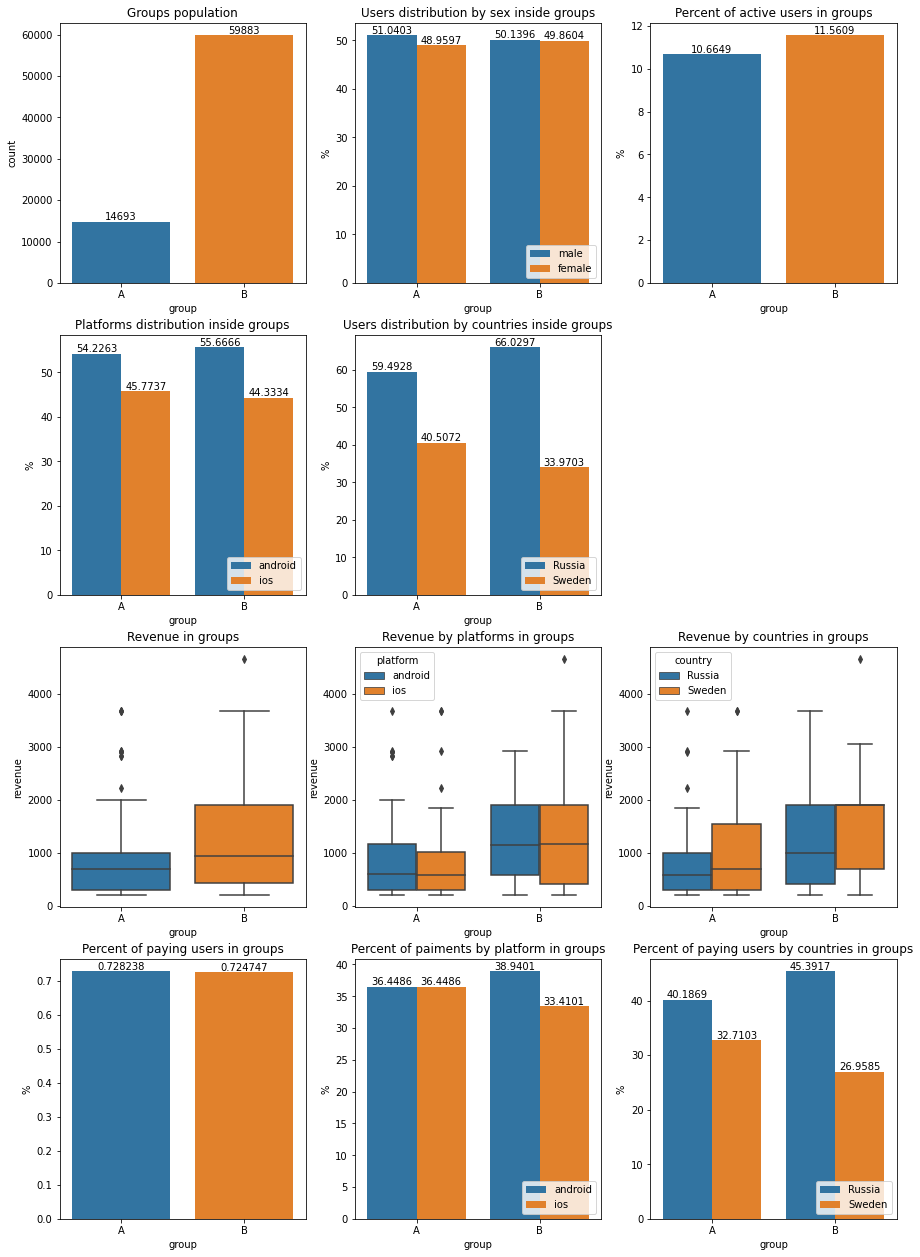

In [175]:
fig, axes = plt.subplots(4, 3, figsize=(15, 22))

# График 0,0 -----------------------------------------------------------------------------------------------------------
ax_0 = sns.countplot(ax=axes[0, 0], 
                     x='group', 
                     data=merged_data, 
                     order=['A', 'B'])

ax_0.bar_label(ax_0.containers[0])
axes[0, 0].set_title('Groups population')

# График 0,1 -----------------------------------------------------------------------------------------------------------
sex_group = (merged_data.groupby('group')['sex']
                .value_counts(normalize=True)
                .mul(100)
                .to_frame()
                .rename(columns={'sex': 'sex_perc'})
                .reset_index())

ax_3 = sns.barplot(ax=axes[0, 1],                    
                   x='group', 
                   y='sex_perc', 
                   hue='sex', 
                   data=sex_group)

ax_3.bar_label(ax_3.containers[0])
ax_3.bar_label(ax_3.containers[1])
axes[0, 1].set_title('Users distribution by sex inside groups')
axes[0, 1].set_ylabel('%') 
axes[0, 1].legend(loc='lower right')

# График 0,2 -----------------------------------------------------------------------------------------------------------
act_usr = merged_data.groupby(['group']).agg({'is_active': 'mean'}).mul(100)

ax_7 = sns.barplot(ax=axes[0, 2], 
                   x=act_usr.index, 
                   y=act_usr.values.flatten(), 
                   order=['A', 'B'])

ax_7.bar_label(ax_7.containers[0])
axes[0, 2].set_title('Percent of active users in groups')
axes[0, 2].set_ylabel('%')

# График 1,0 -----------------------------------------------------------------------------------------------------------
platf_group = (merged_data.groupby('group')['platform']
                .value_counts(normalize = True)
                .mul(100)
                .to_frame()
                .rename(columns={'platform': 'platform_perc'})
                .reset_index())

ax_1 = sns.barplot(ax=axes[1, 0], 
                   x='group', 
                   y='platform_perc', 
                   hue='platform', 
                   data=platf_group)

ax_1.bar_label(ax_1.containers[0])
ax_1.bar_label(ax_1.containers[1])
axes[1, 0].set_title('Platforms distribution inside groups')
axes[1, 0].set_ylabel('%')
axes[1, 0].legend(loc='lower right')

# График 1,1 -----------------------------------------------------------------------------------------------------------
country_group = (merged_data.groupby('group')['country']
                .value_counts(normalize = True)
                .mul(100)
                .to_frame()
                .rename(columns = {'country': 'country_perc'})
                .reset_index())

ax_2 = sns.barplot(ax=axes[1, 1], 
                   x='group', 
                   y='country_perc', 
                   hue='country', 
                   data = country_group)

ax_2.bar_label(ax_2.containers[0])
ax_2.bar_label(ax_2.containers[1])
axes[1, 1].set_title('Users distribution by countries inside groups')
axes[1, 1].set_ylabel('%')
axes[1, 1].legend(loc='lower right')

# График 2,0 -----------------------------------------------------------------------------------------------------------
ax_4 = sns.boxplot(ax=axes[2, 0], 
                   x='group', 
                   y='revenue', 
                   data=merged_data, 
                   order=['A', 'B'])

axes[2, 0].set_title('Revenue in groups')

# График 2,1 -----------------------------------------------------------------------------------------------------------
ax_5 = sns.boxplot(ax=axes[2, 1], 
                   x='group', 
                   y='revenue', 
                   hue='platform', 
                   data=merged_data, 
                   order=['A', 'B'])

axes[2, 1].set_title('Revenue by platforms in groups')

# График 2,2 -----------------------------------------------------------------------------------------------------------
ax_5 = sns.boxplot(ax=axes[2, 2], 
                   x='group', 
                   y='revenue', 
                   hue='country', 
                   data=merged_data, 
                   order=['A', 'B'])

axes[2, 2].set_title('Revenue by countries in groups')

# График 3,0 -----------------------------------------------------------------------------------------------------------
perc_pay_usr = (merged_data[merged_data['revenue'].notnull()].groupby('group')['group'].count() / \
                merged_data.groupby('group')['group'].count() * 100)

ax_6 = sns.barplot(ax=axes[3, 0], 
                   x=perc_pay_usr.index, 
                   y=perc_pay_usr.values, 
                   order=['A', 'B'])

ax_6.bar_label(ax_6.containers[0])
axes[3, 0].set_ylabel('%')
axes[3, 0].set_title('Percent of paying users in groups')  

# График 3,1 -----------------------------------------------------------------------------------------------------------
perc_pay_platform = ((merged_data[merged_data['revenue'].notnull()].groupby(['group', 'platform'])['user_id'].count() /
                    merged_data[merged_data['revenue'].notnull()].groupby('group')['user_id'].count() * 100)
                    .to_frame()
                    .reset_index()
                    .rename(columns={'user_id': 'perc_in_platform'}))

ax_8 = sns.barplot(ax=axes[3, 1], 
                   x='group', 
                   y='perc_in_platform', 
                   hue='platform', 
                   data = perc_pay_platform, 
                   order=['A', 'B'])

ax_8.bar_label(ax_8.containers[0])
ax_8.bar_label(ax_8.containers[1])
axes[3, 1].set_title('Percent of paiments by platform in groups')
axes[3, 1].set_ylabel('%')
axes[3, 1].legend(loc='lower right')

# График 3,2 ------------------------------------------------------------------------------------------------------------
perc_pay_country = ((merged_data[merged_data['revenue'].notnull()].groupby(['group', 'country'])['user_id'].count() / \
                     merged_data[merged_data['revenue'].notnull()].groupby('group')['user_id'].count() * 100)\
                    .to_frame()\
                    .reset_index()\
                    .rename(columns={'user_id': 'perc_in_country'}))

ax_9 = sns.barplot(ax=axes[3, 2], 
                   x='group', 
                   y='perc_in_country', 
                   hue='country', 
                   data=perc_pay_country, 
                   order=['A', 'B'])

ax_9.bar_label(ax_9.containers[0])
ax_9.bar_label(ax_9.containers[1])
axes[3, 2].set_title('Percent of paying users by countries in groups')
axes[3, 2].legend(loc='lower right')
axes[3, 2].set_ylabel('%')

fig.delaxes(ax=axes[1, 2])

plt.show()

### 3. Тестирование гипотез

**Тестовой будет считаться группа B**

При проведении исследования будут рассматриваться следующие метрики:

- доля активных пользователей (для которых есть данные в таблице `active_users`, или для которых есть значение `revenue`)
- доля платящих пользователей (для которых есть значение `revenue`)
- средняя и медианная суммы оплат

Для проверки удачности применения новой модели оплаты будет протестированы гипотезы о равенстве вышеперечсленных метрик в тестовой и контрольной группах.

Т.к. по некоторым срезам данных не много будет дополнительно применяться Bootstrap для уменьшения ошибки.

###### 3.1 Гипотеза о равенстве пропорций активных пользователей в группах

In [176]:
# Число активныхпользователей в группах
active_prop = (merged_data.groupby(['group'])
               .agg(prop_active=('is_active', 'sum'), 
                    num_in_group=('is_active', 'count')))

active_prop

,prop_active,num_in_group
group,,
A,1567,14693
B,6923,59883


In [177]:
# Z тест на равенство пропорций 
from statsmodels.stats.proportion import proportions_ztest

z, p_value = proportions_ztest(active_prop.prop_active.values, 
                               active_prop.num_in_group.values)

print(f'p_value {round(p_value, 4)} \nz_statistics {round(z, 4)}')

p_value 0.0022 
z_statistics -3.0639


p-value оказался меньше 0,05, следовательно **есть статистически значимые различия между пропорциями**, а значение Z-статистики отрицательно, значит **доля активных пользователе в группе B (тестовая) больше, чем в группе A (контрольная).**

##### 3.2 Гипотеза о равенстве пропорций платящих пользователей (случаев оплат) в группах

In [178]:
# Число платящих пользователей в группах
pay_num = (merged_data[merged_data['revenue'].notnull()]
           .groupby('group')['group']
           .count()
           .values)

# Численность групп
group_num = (merged_data.groupby('group')['group']
             .count()
             .values)

# Z-тест на равенство пропорций
z, p = proportions_ztest(pay_num, 
                         group_num)

print(f'p_value {round(p, 4)} \nz_statistics {round(z, 4)}')

p_value 0.9644 
z_statistics 0.0447


p-value больше 0,05, следовательно **статистически значимых различий нет. В группах не изменился процент случаев оплат.**

##### 3.3 Гипотезы о равенстве средних и медианных оплат

##### 3.3.1 Гипотезы о равенстве средних и медианных оплат между группами

In [179]:
# Массивы c оплатами пользователей по разным группам
revenue_A = merged_data[merged_data['group'] == 'A']['revenue'].dropna().values
revenue_B = merged_data[merged_data['group'] == 'B']['revenue'].dropna().values

In [180]:
# Дисперсии оплат
revenue_A.std() ** 2, revenue_B.std() ** 2

(659432.8930037558, 549032.9202414578)

т.к. диспресии отличаются будет использоваться тест Уэлча

In [181]:
# тест Уэлча
t_st, p_val = ttest_ind(revenue_A, 
                        revenue_B, 
                        equal_var=False)

print(f'p_value {round(p_val, 4)} \nt_statistics {round(t_st, 4)}')

p_value 0.0047 
t_statistics -2.8676


p_value меньше 0,05, значит **есть статистически значимые различия в средних платежах**. Значение статистики отрицательно, значит **среднее значение платежей группы B (тестовой) больше.**

Для уточнения результатов теста Уэлча на исходных выборках будет использоваться Bootstrap. Будет исследоваться разность средних семплированных выборок. Долее будет строится доверительный интервал для разности средних. Если в него попадает 0 значит статистически значимых отличий в средних нет, в противном случае они есть. 

In [182]:
# Bootstrap
DELTA_means = []
means_rev_A = []
means_rev_B = []

DELTA_medians = []
medians_rev_A = []
medians_rev_B = []

for i in range(10000):
    sample_rev_A = np.random.choice(revenue_A, 
                         size=len(revenue_A), 
                         replace=True)
    
    sample_rev_B = np.random.choice(revenue_B, 
                         size=len(revenue_B), 
                         replace=True)
    
    mean_sample_rev_A = np.mean(sample_rev_A)
    mean_sample_rev_B = np.mean(sample_rev_B)
    
    median_sample_rev_A = np.median(sample_rev_A)
    median_sample_rev_B = np.median(sample_rev_B)
    
    delta_mean = mean_sample_rev_A - mean_sample_rev_B
    delta_median = median_sample_rev_A - median_sample_rev_B
    
    means_rev_A.append(mean_sample_rev_A)
    means_rev_B.append(mean_sample_rev_B)
    medians_rev_A.append(median_sample_rev_A)
    medians_rev_B.append(median_sample_rev_B)
    DELTA_means.append(delta_mean)
    DELTA_medians.append(delta_median)

In [183]:
# Доверительный интервал для разности средних оплат
a = 0.95
SE = np.std(DELTA_means) / np.sqrt(len(DELTA_means))
T = t.ppf((1 - a) / 2, 
          len(DELTA_means) - 1)
np.mean(DELTA_means) - SE * T, np.mean(DELTA_means) + SE * T

(-247.83997859145114, -251.16892650351423)

0 не попадает в доверительный интервал, значит **различия в средних значениях суммы платежей есть**. Значения обеих границ доверительного интервала отрицательно, значит **среднее значение суммы платежей группы B (тестовой) больше.**

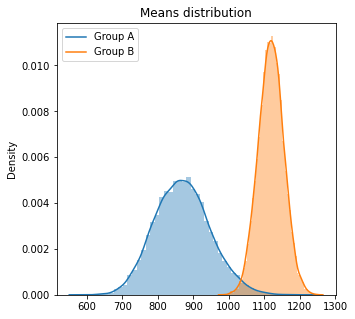

In [184]:
# Распределение средгних сумм оплат семплированных выборок
plt.figure(figsize=(5,5))
sns.distplot(means_rev_A)
sns.distplot(means_rev_B)
plt.legend(['Group A', 'Group B'])
plt.title('Means distribution')
plt.show()

Для проверки гипотезы о равенстве медиан оплат в группах будет использоватся медианных тест, а также дополнительно проверка попадание 0 в доверительный интервал разностей медиан групп из семплированных выборок

In [185]:
# Медианный тест
chi2, p = median_test(medians_rev_A, 
                      medians_rev_B)[0:2]

print(f'p_value {round(p, 4)} \nchi2_statistics {round(chi2, 4)}')

p_value 0.0 
chi2_statistics 19960.025


p_value меньше 0,05, значит **есть статистически значимые различия в средних платежах.**

In [186]:
# Доверительный интервал для разности медиан сумм оплаты
a = 0.95
SE = np.std(DELTA_medians) / np.sqrt(len(DELTA_medians))
T = t.ppf((1 - a) / 2, 
          len(DELTA_medians) - 1)
np.mean(DELTA_medians) - SE * T, np.mean(DELTA_medians) + SE * T

(-280.1350956094675, -283.55490439053256)

0 не попадает в доверительный интервал, значит **различия в медианных значениях платежей есть**. Значения обеих границ доверительного интервала отрицательно, значит **медианное значение платежей группы B (тестовой) больше.**

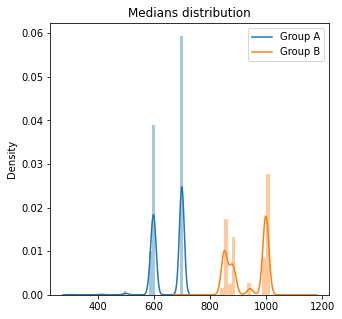

In [187]:
# Распределение медиан сумм оплат семплированных выборок
plt.figure(figsize=(5,5))
sns.distplot(medians_rev_A)
sns.distplot(medians_rev_B)
plt.title('Medians distribution')
plt.legend(['Group A', 'Group B'])
plt.show()

##### 3.3.1 Гипотеза о равенстве средних и медианных платежей по платформам между группами

In [188]:
# Массивы с оплатами по группам и платформам
rev_ios_A = merged_data[(merged_data['platform'] == 'ios') & 
                        (merged_data['group'] == 'A')]['revenue'].dropna().values

rev_ios_B = merged_data[(merged_data['platform'] == 'ios') & 
                        (merged_data['group'] == 'B')]['revenue'].dropna().values

rev_android_A = merged_data[(merged_data['platform'] == 'android') & 
                            (merged_data['group'] == 'A')]['revenue'].dropna().values

rev_android_B = merged_data[(merged_data['platform'] == 'android') & 
                            (merged_data['group'] == 'B')]['revenue'].dropna().values

In [189]:
# Размеры выборок
len(rev_ios_A), len(rev_ios_B), len(rev_android_A), len(rev_android_B)

(39, 145, 39, 169)

In [190]:
# Дисперсии оплат по группам iOS
rev_ios_A.std(), rev_ios_B.std()

(874.1849183850561, 860.6780379963111)

In [191]:
# Дисперсии оплат по группам android
rev_android_A.std(), rev_android_B.std()

(945.4872434610982, 721.1800471040671)

Размеры выборок позволяют провести обычный t-тест, но т.к. диспперсии не одинаковы будет использоватся модификация Уэлча. Дополнительно гипотезы будут тестироватся с помощью построения доверительного интервала для разницы средних и медиан из семплированных (бутстрапированных) выборок.

In [192]:
# Bootstrap
means_ios_A = []
means_ios_B = []
means_android_A = []
means_android_B = []

medians_ios_A = []
medians_ios_B = []
medians_android_A = []
medians_android_B = []

DELTA_means_ios = []
DELTA_means_android = []
DELTA_medians_ios = []
DELTA_medians_android = []

for i in range(10000):
    ios_A = np.random.choice(rev_ios_A, 
                             size=len(rev_ios_A), 
                             replace=True)  
    
    ios_B = np.random.choice(rev_ios_B, 
                             size=len(rev_ios_B), 
                             replace=True)
    
    android_A = np.random.choice(rev_android_A, 
                                 size=len(rev_android_A), 
                                 replace=True)
    
    android_B = np.random.choice(rev_android_B, 
                                 size=len(rev_android_B), 
                                 replace=True)
    
    medians_ios_A.append(np.median(ios_A))
    medians_ios_B.append(np.median(ios_B))
    medians_android_A.append(np.median(android_A))
    medians_android_B.append(np.median(android_B))
    
    delta_means_ios = np.mean(ios_A) - np.mean(ios_B)
    delta_means_android = np.mean(android_A) - np.mean(android_B)
    delta_medians_ios = np.median(ios_A) - np.median(ios_B)
    delta_medians_android = np.median(android_A) - np.median(android_B)    
    
    
    DELTA_means_ios.append(delta_means_ios)
    DELTA_means_android.append(delta_means_android)
    DELTA_medians_ios.append(delta_medians_ios)
    DELTA_medians_android.append(delta_medians_android)

$$ mean\:revenue\:iOS\:(A) - mean\:revenue\:iOS\:(B) $$
$$ mean\:revenue\:android\:(A) - mean\:android\:iOS\:(B) $$

In [193]:
# Тест Уэлча для средних оплат в группах iOS
t_st, p_val = ttest_ind(rev_ios_A, 
                        rev_ios_B, 
                        equal_var=False)

print(f'p_value {round(p_val, 4)} \nt_statistics {round(t_st, 4)}')

p_value 0.0069 
t_statistics -2.8007


p_value меньше 0,05, значит **есть статистически значимые различия в средних платежах для платформы iOS**. Значение статистики отрицательно, значит **среднее значение платежей группы B (тестовой) больше.**

In [194]:
# Доверительный интервал для разности средних оплат iOS
a = 0.95
SE = np.std(DELTA_means_ios) / np.sqrt(len(DELTA_means_ios))
T = t.ppf((1 - a) / 2, 
          len(DELTA_means_ios) - 1)
np.mean(DELTA_means_ios) - SE * T, np.mean(DELTA_means_ios) + SE * T

(-445.1342072383035, -451.2587803125365)

0 не попадает в доверительный интервал, значит **различия в средних значениях платежей для iOS есть**. Значения обеих границ доверительного интервала отрицательно, значит **среднее значение платежей на платформе iOS в группе B (тестовой) больше.**

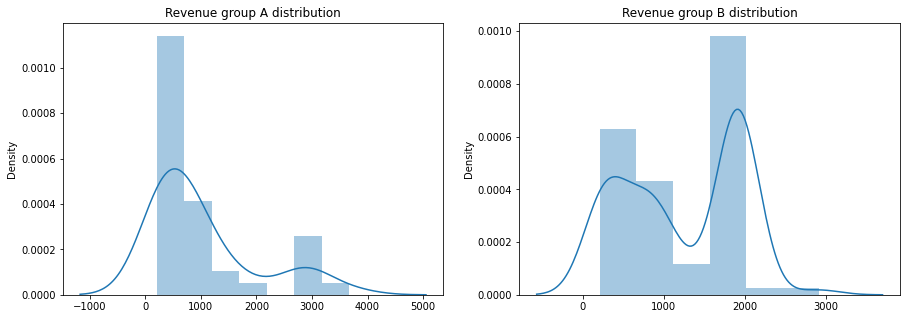

In [195]:
# Распределение исходных выборок (оплаты в группах с платформой android)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax_0 = sns.distplot(rev_android_A, ax=axes[0])
ax_1 = sns.distplot(rev_android_B, ax=axes[1])

axes[0].set_title('Revenue group A distribution')
axes[1].set_title('Revenue group B distribution')

plt.show()

In [196]:
# Тест Уэлча для средних оплат в группах android
t_st, p_val = ttest_ind(rev_android_A, 
                        rev_android_B, 
                        equal_var=False)

print(f'p_value {round(p_val, 4)} \nt_statistics {round(t_st, 4)}')

p_value 0.2054 
t_statistics -1.2835


p_value ,больше 0,05, значит **статистически значимых различий в средних платежах для платформы android нет**.

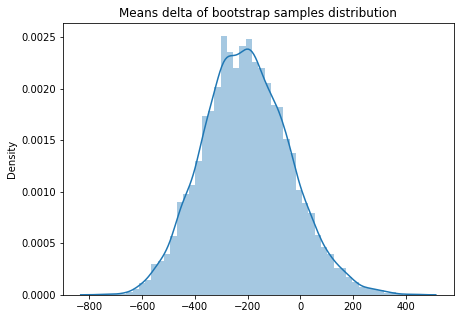

In [197]:
# Распределение разностей средних бутстрапированых выборок (оплаты в группах с платформой android)
plt.figure(figsize=(7, 5))
sns.distplot(DELTA_means_android)
plt.title('Means delta of bootstrap samples distribution')
plt.show()

In [198]:
# Доверительный интервал для разности средних оплат android
a = 0.95
SE = np.std(DELTA_means_android) / np.sqrt(len(DELTA_means_android))
T = t.ppf((1 - a) / 2, 
          len(DELTA_means_android) - 1)
np.mean(DELTA_means_android) - SE * T, np.mean(DELTA_means_android) + SE * T

(-201.56325641479614, -207.98124891064768)

0 не попадает в доверительный интервал, значит **различия в средних значениях платежей для android есть**. Значения обеих границ доверительного интервала отрицательно, значит **среднее значение платежей на платформе android в группе B (тестовой) больше.**

Т.к. распределение исходных выборок далеко от нормального, то будем доверять результату бутстрапа, **т.е. средние значеия оплаты для android в группах имеют стат.значимые различия, и для группы B (тестовой) среднее значение платежей больше.**

$$ median\:revenue\:iOS\:(A) - median\:revenue\:iOS\:(B) $$
$$ median\:revenue\:android\:(A) - median\:android\:iOS\:(B) $$

In [199]:
# Медианный тест для iOS
chi2, p = median_test(medians_ios_A, 
                      medians_ios_B)[0:2]

print(f'p_value {round(p, 4)} \nchi2_statistics {round(chi2, 4)}')

p_value 0.0 
chi2_statistics 19318.4193


p_value меньше 0,05, значит **есть статистически значимые различия в медианных значениях платежей на платформе iOS.**

In [200]:
# Доверительный интервал для разности медианных оплат iOS
from scipy.stats import t
a = 0.95
SE = np.std(DELTA_medians_ios) / np.sqrt(len(DELTA_medians_ios))
T = t.ppf((1 - a) / 2, 
          len(DELTA_medians_ios) - 1)
np.mean(DELTA_medians_ios) - SE * T, np.mean(DELTA_medians_ios) + SE * T

(-818.0567466070529, -832.236053392947)

0 не попадает в доверительный интервал, значит **различия в медианных значениях платежей для платформы iOS есть**. Значения обеих границ доверительного интервала отрицательно, значит **среднее значение платежей на платформе iOS в группе B (тестовой) больше.**

In [201]:
# Медианный тест для android
chi2, p = median_test(medians_android_A, 
                      medians_android_B)[0:2]

print(f'p_value {round(p, 4)} \nchi2_statistics {round(chi2, 4)}')

p_value 0.0 
chi2_statistics 16516.4902


p_value меньше 0,05, значит **есть статистически значимые различия в медианных значениях платежей на платформе android.**

In [202]:
# Доверительный интервал для разности медианных оплат android
a = 0.95
SE = np.std(DELTA_medians_android) / np.sqrt(len(DELTA_medians_android))
T = t.ppf((1 - a) / 2, 
          len(DELTA_medians_android) - 1)
np.mean(DELTA_medians_android) - SE * T, np.mean(DELTA_medians_android) + SE * T

(-622.185300775862, -636.532099224138)

0 не попадает в доверительный интервал, значит **различия в медианных значениях платежей для платформы android есть**. Значения обеих границ доверительного интервала отрицательно, значит **медианное значение платежей на платформе android в группе B (тестовой) больше.**

Во всех случаях **есть статистически значимые различия в средних и медианных значниях сумм оплаты по платформам между группами.** Во всех случаях **для группы B (тестовая) исследуемые величины больше, чем для группы A (контрольная).**

##### 3.3.2 Гипотеза о равенстве средних и медианных платежей по странам между группами

In [203]:
# Массивы с оплатами по группам и странам
rev_rus_A = merged_data[(merged_data['country'] == 'Russia') & 
                        (merged_data['group'] == 'A')]['revenue'].dropna().values

rev_rus_B = merged_data[(merged_data['country'] == 'Russia') & 
                        (merged_data['group'] == 'B')]['revenue'].dropna().values

rev_swe_A = merged_data[(merged_data['country'] == 'Sweden') & 
                        (merged_data['group'] == 'A')]['revenue'].dropna().values

rev_swe_B = merged_data[(merged_data['country'] == 'Sweden') & 
                         (merged_data['group'] == 'B')]['revenue'].dropna().values

In [204]:
# Размеры выборок
len(rev_rus_A), len(rev_rus_B), len(rev_swe_A), len(rev_swe_B)

(43, 197, 35, 117)

In [205]:
# Дисперсии оплат по России
rev_rus_A.std() ** 2, rev_rus_B.std() ** 2

(608870.8015143321, 592541.4851709655)

In [206]:
# Дисперсии оплат по Швеции
rev_swe_A.std() ** 2, rev_swe_B.std() ** 2

(1074155.684897959, 663107.1274746148)

Размеры выборок позволяют провести обычный t-тест, но т.к. диспперсии не одинаковы будет использоватся модификация Уэлча. Дополнительно гипотезы будут тестироватся с помощью построения доверительного интервала для разницы средних и медиан из семплированных выборок.

In [207]:
# Bootstrap 
means_rus_A = []
means_rus_B = []
means_swe_A = []
means_swe_B = []

medians_rus_A = []
medians_rus_B = []
medians_swe_A = []
medians_swe_B = []

DELTA_means_rus = []
DELTA_means_swe = []
DELTA_medians_rus = []
DELTA_medians_swe = []

for i in range(10000):
    rus_A = np.random.choice(rev_rus_A, 
                             size=len(rev_rus_A), 
                             replace=True) 
    
    rus_B = np.random.choice(rev_rus_B, 
                             size=len(rev_rus_B), 
                             replace=True)
    
    swe_A = np.random.choice(rev_swe_A, 
                             size=len(rev_swe_A), 
                             replace=True)
    
    swe_B = np.random.choice(rev_swe_B, 
                             size=len(rev_swe_B), 
                             replace=True)
    
    means_rus_A.append(np.mean(rus_A))
    means_rus_B.append(np.mean(rus_B))
    means_swe_A.append(np.mean(swe_A))
    means_swe_B.append(np.mean(swe_B))
      
    medians_rus_A.append(np.median(rus_A))
    medians_rus_B.append(np.median(rus_B))
    medians_swe_A.append(np.median(swe_A))
    medians_swe_B.append(np.median(swe_B))
    
    delta_means_rus = np.mean(rus_A) - np.mean(rus_B)
    delta_means_swe = np.mean(swe_A) - np.mean(swe_B)
    
    delta_medians_rus = np.median(rus_A) - np.median(rus_B)
    delta_medians_swe = np.median(swe_A) - np.median(swe_B)
    
    DELTA_means_rus.append(delta_means_rus)
    DELTA_means_swe.append(delta_means_swe)
    DELTA_medians_rus.append(delta_medians_rus)
    DELTA_medians_swe.append(delta_medians_swe)

$$ mean\:revenue\:Russia\:(A) - mean\:revenue\:Russia\:(B) $$
$$ mean\:revenue\:Sweden\:(A) - mean\:android\:Sweden\:(B) $$

In [208]:
# Тест Уэлча для средних оплат между группами в России
t_st, p_val = ttest_ind(means_rus_A, 
                        means_rus_B, 
                        equal_var=False)

print(f'p_value {round(p_val, 4)} \nt_statistics {round(t_st, 4)}')

p_value 0.0 
t_statistics -301.0171


p_value меньше 0,05, значит **есть статистически значимые различия в средних платежах по России**. Значение статистики отрицательно, значит **среднее значение платежей группы B (тестовой) больше.**

In [209]:
# Доверительный интервал для разности средних оплат по России
a = 0.95
SE = np.std(DELTA_means_rus) / np.sqrt(len(DELTA_means_rus))
T = t.ppf((1 - a) / 2, 
          len(DELTA_means_rus) - 1)
np.mean(DELTA_means_rus) - SE * T, np.mean(DELTA_means_rus) + SE * T

(-391.27444365670317, -396.404345884083)

0 не попадает в доверительный интервал, значит **различия в средних значениях платежей по России есть**. Значения обеих границ доверительного интервала отрицательно, значит **среднее значение платежей по России в группе B (тестовой) больше.**

In [210]:
# Тест Уэлча для средних оплат между группами в Швеции
t_st, p_val = ttest_ind(means_swe_A, 
                        means_swe_B, 
                        equal_var=False)

print(f'p_value {round(p_val, 4)} \nt_statistics {round(t_st, 4)}')

p_value 0.0 
t_statistics -136.8624


p_value меньше 0,05, значит **есть статистически значимые различия в средних платежах по Швеции**. Значение статистики отрицательно, значит **среднее значение платежей группы B (тестовой) больше.**

In [211]:
# Доверительный интервал для разности средних оплат по Швеции
a = 0.95
SE = np.std(DELTA_means_swe) / np.sqrt(len(DELTA_means_swe))
T = t.ppf((1 - a) / 2, 
          len(DELTA_means_swe) - 1)
np.mean(DELTA_means_swe) - SE * T, np.mean(DELTA_means_swe) + SE * T

(-259.76757336720823, -267.32715947772465)

0 не попадает в доверительный интервал, значит **различия в средних значениях платежей по Швеции есть**. Значения обеих границ доверительного интервала отрицательно, значит **среднее значение платежей по Швеции в группе B (тестовой) больше.**

$$ median\:revenue\:Russia\:(A) - median\:revenue\:Russia\:(B) $$
$$ median\:revenue\:Sweden\:(A) - median\:android\:Sweden\:(B) $$

In [212]:
# Медианный тест для России
chi2, p = median_test(medians_rus_A, 
                      medians_rus_B)[0:2]

print(f'p_value {round(p, 4)} \nchi2_statistics {round(chi2, 4)}')

p_value 0.0 
chi2_statistics 19286.4848


p_value меньше 0,05, значит **есть статистически значимые различия в медианных значениях платежей по России.**

In [213]:
# Доверительный интервал для разности медианных оплат по России
a = 0.95
SE = np.std(DELTA_medians_rus) / np.sqrt(len(DELTA_medians_rus))
T = t.ppf((1 - a) / 2, 
          len(DELTA_medians_rus) - 1)
np.mean(DELTA_medians_rus) - SE * T, np.mean(DELTA_medians_rus) + SE * T

(-555.3202690908723, -564.4407309091276)

0 не попадает в доверительный интервал, значит **различия в медианных значениях платежей по России есть**. Значения обеих границ доверительного интервала отрицательно, значит **медианное значение платежей по России в группе B (тестовой) больше.**

In [214]:
# Медианный тест для Швеции
chi2, p = median_test(medians_swe_A, 
                      medians_swe_B)[0:2]

print(f'p_value {round(p, 4)} \nchi2_statistics {round(chi2, 4)}')

p_value 0.0 
chi2_statistics 17444.8607


p_value меньше 0,05, значит **есть статистически значимые различия в медианных значениях платежей по Швеции.**

In [215]:
# Доверительный интервал для разности медианных оплат по Швеции
a = 0.95
SE = np.std(DELTA_medians_swe) / np.sqrt(len(DELTA_medians_swe))
T = t.ppf((1 - a) / 2, 
          len(DELTA_medians_swe) - 1)
np.mean(DELTA_medians_swe) - SE * T, np.mean(DELTA_medians_swe) + SE * T

(-1030.7924818381287, -1045.8377181618714)

0 не попадает в доверительный интервал, значит **различия в медианных значениях платежей по Швеции есть**. Значения обеих границ доверительного интервала отрицательно, значит **медианное значение платежей по Швеции в группе B (тестовой) больше.**

Во всех случаях **есть статистически значимые различия в средних и медианных значниях сумм оплаты по странам между группами.** Во всех случаях **для группы B (тестовая) исследуемые величины больше, чем для группы A (контрольная).**

##### 3.4 Гипотезы о равенстве пропорций платящих пользователей

##### 3.4.1 Гипотезы о равенстве пропорций платящих пользователей (случаев оплаты) по платформам между группами

$$ \%\:paying\:users\:iOS\:(A) - \%\:paying\:users\:iOS\:(B) $$
 
$$ \%\:paying\:users\:Android\:(A) - \%\:paying\:users\:Android\:(B) $$

In [216]:
# Количество платящих пользователей с платформой iOS в группах
pay_ios_A = merged_data[(merged_data['platform'] == 'ios') & 
                        (merged_data['group'] == 'A')]['revenue'].count()

pay_ios_B = merged_data[(merged_data['platform'] == 'ios') & 
                        (merged_data['group'] == 'B')]['revenue'].count()

# Количество пользователей с платформой iOS в группах 
ios_A = merged_data[(merged_data['platform'] == 'ios') & 
                    (merged_data['group'] == 'A')]['user_id'].count()

ios_B = merged_data[(merged_data['platform'] == 'ios') & 
                    (merged_data['group'] == 'B')]['user_id'].count()

# Количество платящих пользователей с платформой android в группах 
pay_android_A = merged_data[(merged_data['platform'] == 'android') & 
                            (merged_data['group'] == 'A')]['revenue'].count()

pay_android_B = merged_data[(merged_data['platform'] == 'android') & 
                            (merged_data['group'] == 'B')]['revenue'].count()

# Количество пользователей с платформой android в группах
android_A = merged_data[(merged_data['platform'] == 'android') & 
                        (merged_data['group'] == 'A')]['user_id'].count()

android_B = merged_data[(merged_data['platform'] == 'android') & 
                        (merged_data['group'] == 'B')]['user_id'].count()

In [217]:
# Z-тест на равенство пропорций платящих пользователей с платформой iOS в группах
z, p = proportions_ztest([pay_ios_A, pay_ios_B], 
                         [ios_A, ios_B])

print(f'p_value {round(p, 4)} \nz_statistics {round(z, 4)}')

p_value 0.4199 
z_statistics 0.8066


In [218]:
# Z-тест на равенство пропорций платящих пользователей с платформой android в группах
z, p = proportions_ztest([pay_android_A, pay_android_B], 
                         [android_A, android_B])

print(f'p_value {round(p, 4)} \nz_statistics {round(z, 4)}')

p_value 0.7876 
z_statistics 0.2694


Во всех случаях p-value больше 0.05, следовательно **статистически значимых различий между пропорциями платящих пользователей между группами, как по платформам, так по странам нет.**

##### 3.4.2 Гипотезы о равенстве пропорций платящих пользователей (случаев оплаты) по странам между группами

In [219]:
# Количество платящих пользователей в России по группам
pay_rus_A = merged_data[(merged_data['country'] == 'Russia') & 
                        (merged_data['group'] == 'A')]['revenue'].count()

pay_rus_B = merged_data[(merged_data['country'] == 'Russia') & 
                        (merged_data['group'] == 'B')]['revenue'].count()

# Количество пользователей в России по группам
rus_A = merged_data[(merged_data['country'] == 'Russia') & 
                    (merged_data['group'] == 'A')]['user_id'].count()

rus_B = merged_data[(merged_data['country'] == 'Russia') & 
                    (merged_data['group'] == 'B')]['user_id'].count()

# Количество платящих пользователей в Швеции по группам
pay_swe_A = merged_data[(merged_data['country'] == 'Sweden') & 
                        (merged_data['group'] == 'A')]['revenue'].count()

pay_swe_B = merged_data[(merged_data['country'] == 'Sweden') & 
                        (merged_data['group'] == 'B')]['revenue'].count()

# Количество пользователей в Швеции по группам
swe_A = merged_data[(merged_data['country'] == 'Sweden') & 
                    (merged_data['group'] == 'A')]['user_id'].count()

swe_B = merged_data[(merged_data['country'] == 'Sweden') & 
                    (merged_data['group'] == 'B')]['user_id'].count()

In [220]:
# Z-тест на равенство пропорций платящих пользователей в группах в России 
z, p = proportions_ztest([pay_rus_A, pay_rus_B], 
                         [rus_A, rus_B])

print(f'p_value {round(p, 4)} \nz_statistics {round(z, 4)}')

p_value 0.6743 
z_statistics 0.4202


In [221]:
# Z-тест на равенство пропорций платящих пользователей в группах в Швеции 
z, p = proportions_ztest([pay_swe_A, pay_swe_B], 
                         [swe_A, swe_B])

print(f'p_value {round(p, 4)} \nz_statistics {round(z, 4)}')

p_value 0.5789 
z_statistics 0.5549


Во всех случаях p-value больше 0.05, следовательно **статистически значимых различий между пропорциями платящих пользователей между группами, как по странам, так по странам нет.**

### Вывод по тестированю гипотез

Были протестированы гипотезы:

- О равенстве пропорций активных пользователей в группах
- О равенстве пропорций платящих пользователей (случаев оплат) в группах
- О равенстве средних и медианных сумм оплаты:
    - О равенстве средних и медианных сумм оплаты между группами
    - О равенстве средних и медианных платежей по платформам между группами
    - О равенстве средних и медианных платежей по странам между группами
- О равенстве пропорций платящих пользователей:
    - О равенстве пропорций платящих пользователей (случаев оплаты) по платформам между группами
    - О равенстве пропорций платящих пользователей (случаев оплаты) по странам между группами

Переход к новой модели оплаты привел к повышению среднего и медианного платежей, а также повышению доли активных пользователей, т.е. увеличению интереса к продукту. Анализ повышений при разбивке по странам и платформам показал, что повышения происходят независимо от платформы и страны, т.е. это не связано со страной или платформой. Таким образом, наблюдается общий эффект повышения интереса и уровня платежей при переходе от старой модели оплаты к новой. **Новую модель оплаты можно раскатать на всех пользователей.**

### Дополнения

##### Д1. Дополнительная инфографика по странам

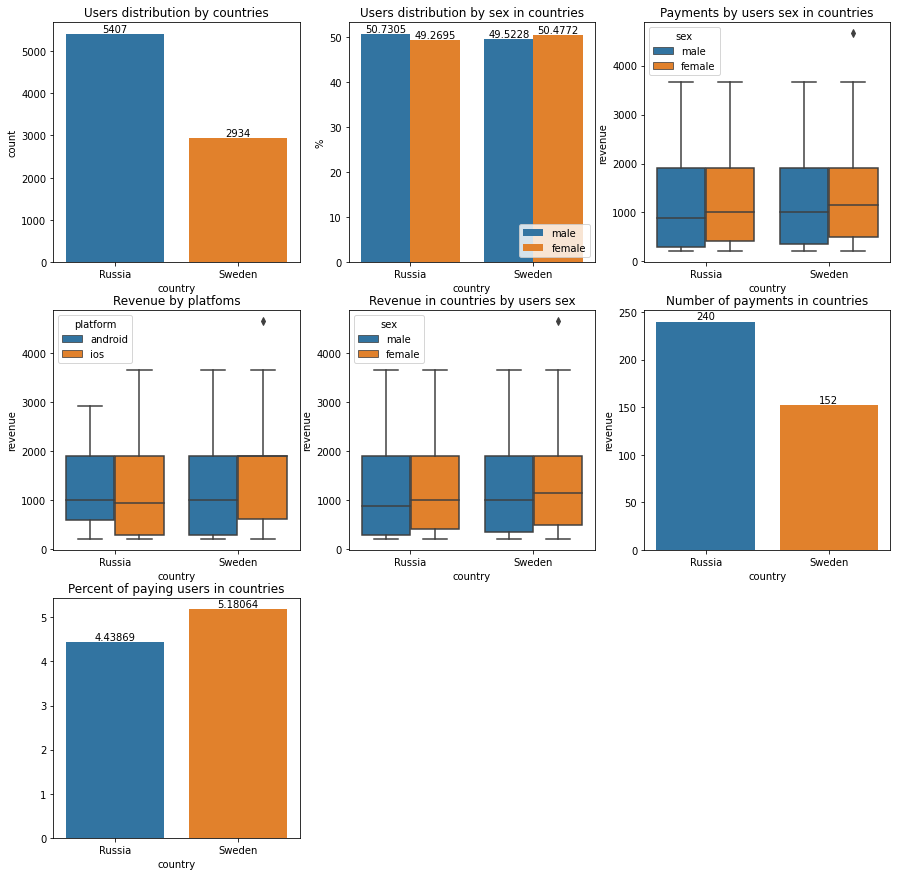

In [222]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# График 0,0 -----------------------------------------------------------------------------------------------------------
ax_0 = sns.countplot(ax=axes[0, 0], 
                     x='country', 
                     data=merged_data)

ax_0.bar_label(ax_0.containers[0])
axes[0, 0].set_title('Users distribution by countries')

# График 0,1 -----------------------------------------------------------------------------------------------------------
sex_perc_countr = (merged_data
                    .groupby('country')['sex']
                    .value_counts(normalize=True)
                    .mul(100))

sex_perc_countr = (sex_perc_countr
                   .to_frame()
                   .rename(columns={'sex': 'sex_perc'})
                   .reset_index())

ax_1 = sns.barplot(ax=axes[0, 1], 
                   x='country', 
                   y='sex_perc', 
                   hue='sex', 
                   data=sex_perc_countr)

ax_1.bar_label(ax_1.containers[0])
ax_1.bar_label(ax_1.containers[1])
axes[0, 1].set_title('Users distribution by sex in countries') 
axes[0, 1].set_ylabel('%')
axes[0, 1].legend(loc='lower right')

# График 0,2 -----------------------------------------------------------------------------------------------------------
ax_2 = sns.boxplot(ax=axes[0, 2], 
                   x='country', 
                   y='revenue', 
                   hue='sex', 
                   data=merged_data)

axes[0, 2].set_title('Payments by users sex in countries')

# График 1,0 ----------------------------------------------------------------------------------------------------------- 
ax_3 = sns.boxplot(ax=axes[1, 0], 
                   x='country', 
                   y='revenue', 
                   hue='platform', 
                   data=merged_data)

axes[1, 0].set_title('Revenue by platfoms')

# График 1,1 ----------------------------------------------------------------------------------------------------------- 
ax_4 = sns.boxplot(ax=axes[1, 1], 
                   x='country', 
                   y='revenue', 
                   hue='sex', 
                   data=merged_data)

axes[1, 1].set_title('Revenue in countries by users sex')

# График 1,2 ----------------------------------------------------------------------------------------------------------- 
ax_5 = sns.barplot(ax=axes[1, 2], 
                   x='country', 
                   y='revenue', 
                   data=merged_data, 
                   estimator=len)

ax_5.bar_label(ax_5.containers[0])
axes[1, 2].set_title('Number of payments in countries')

# График 2,2 ----------------------------------------------------------------------------------------------------------- 
perc_pay_countr = (merged_data[merged_data['revenue'].notnull()]
                   .groupby('country')['country'].count() / 
                   merged_data.groupby('country')['country'].count() * 100)
ax_6 = sns.barplot(ax=axes[2, 0], 
                   x=perc_pay_countr.index, 
                   y=perc_pay_countr.values.flatten())
ax_6.bar_label(ax_6.containers[0])
axes[2, 0].set_title('Percent of paying users in countries')

fig.delaxes(ax = axes[2, 1])
fig.delaxes(ax = axes[2, 2])

plt.show()

##### Д2. Дополнительная инфографика по полу пользователей

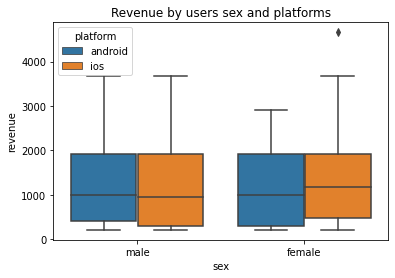

In [223]:
sns.boxplot(x='sex', 
            y='revenue', 
            hue='platform', 
            data=merged_data)

plt.title('Revenue by users sex and platforms')
plt.show()

[ссылка на дашборд](https://public.tableau.com/app/profile/alex3577/viz/FinalProjectKC4var/Dashboard1?publish=yes)